In [1]:
from dataclasses import dataclass

import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from OrgansUtils import *
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
from SegmentModule import *
from OrgansDataset import *
from OrgansUtils import *

In [3]:
ckpt = '/home/setupishe/segment_ac_organs/checkpoints/Run_2024-03-13_00-26-36_/organs_segmentator_epoch=17.ckpt'
overfit_ckpt = '/home/setupishe/segment_ac_organs/checkpoints/Run_2024-03-13_00-26-36_/organs_segmentator_epoch=23.ckpt'

In [4]:
model = SegmentModule.load_from_checkpoint(ckpt)

In [5]:
dataset_path = os.path.join('../data', default_config['dataset_path'])

In [6]:
val_dataset = OrgansDataset(
    os.path.join(dataset_path, 'val'),
    img_size=default_config['img_size'],
    used_classes=default_config['used_classes'],
    clip_max=default_config['clip_max'],
    clip_min=default_config['clip_min'],
    )

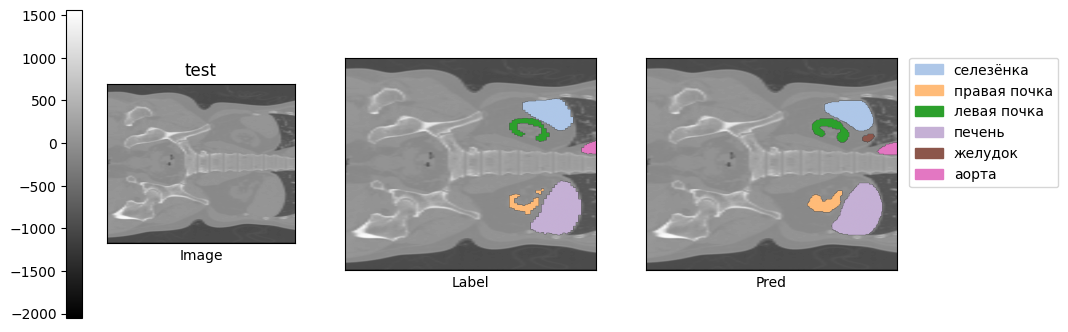

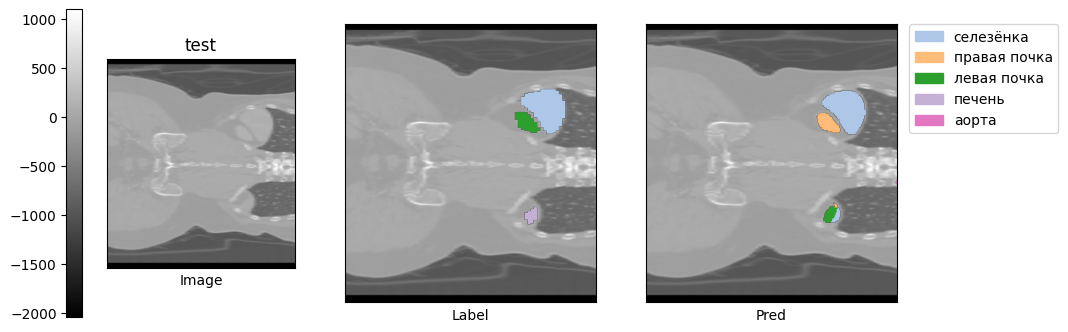

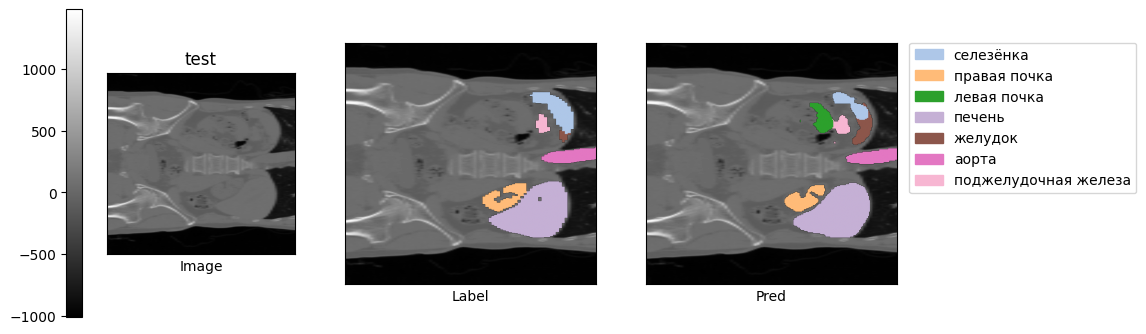

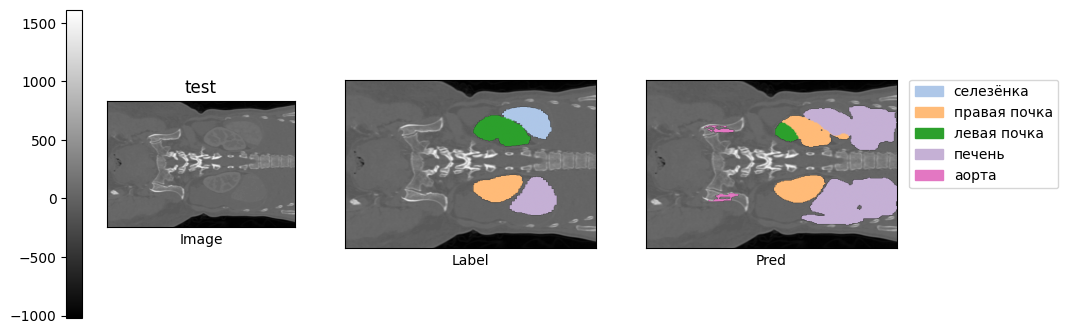

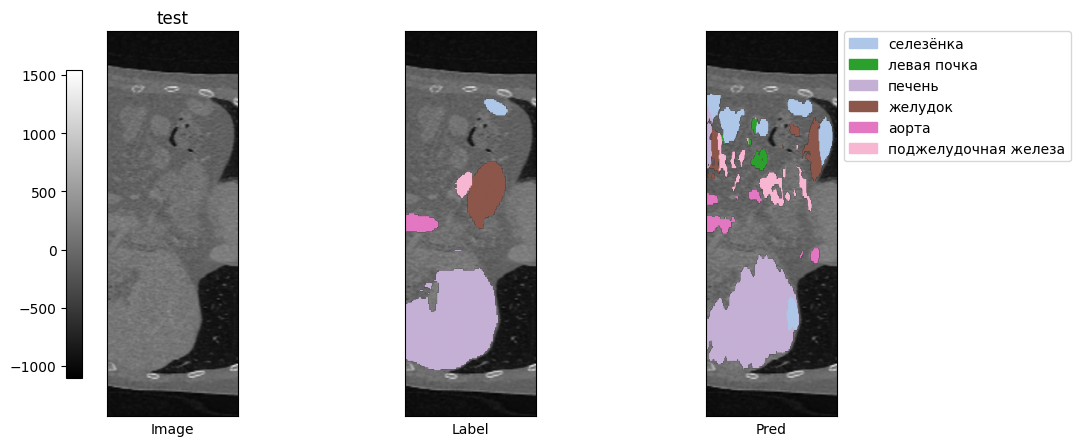

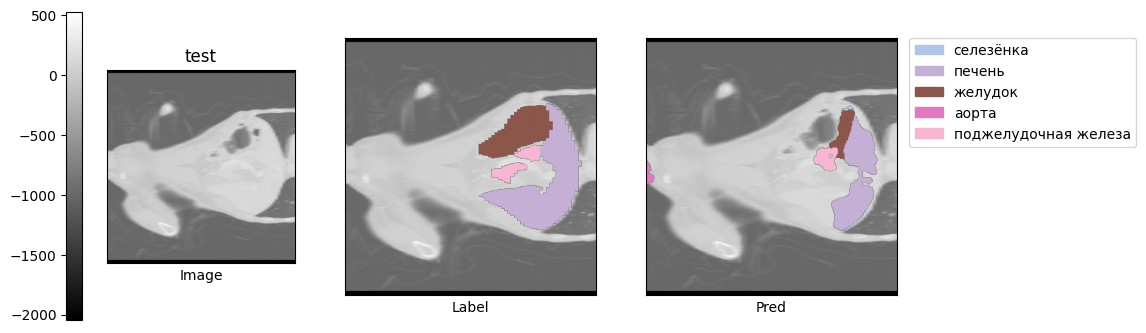

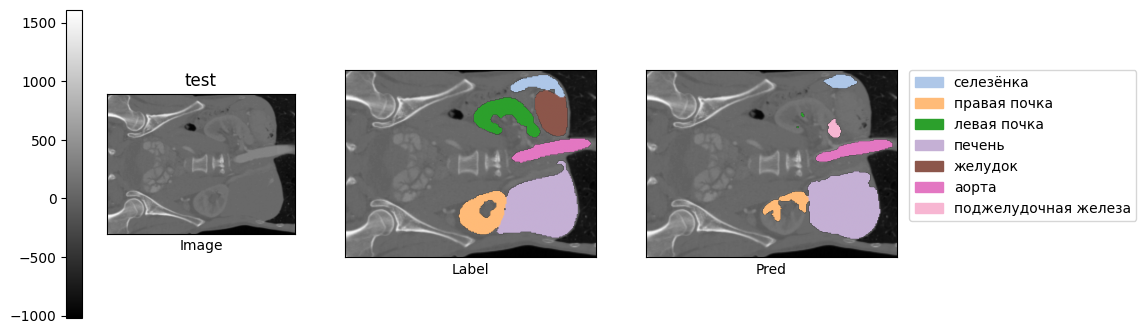

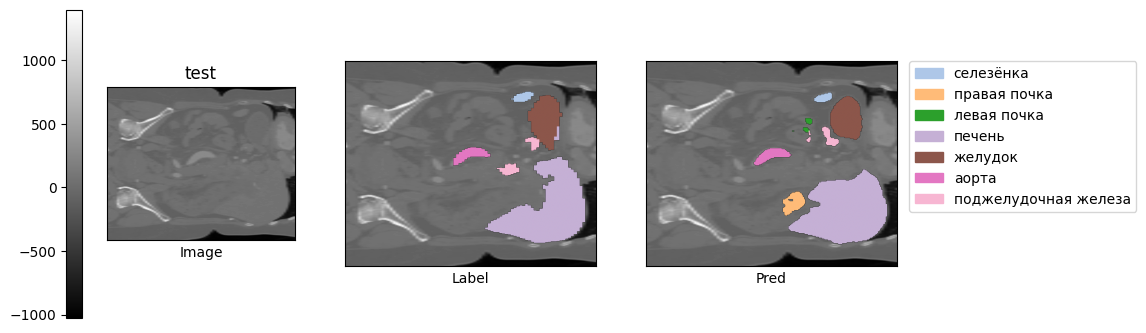

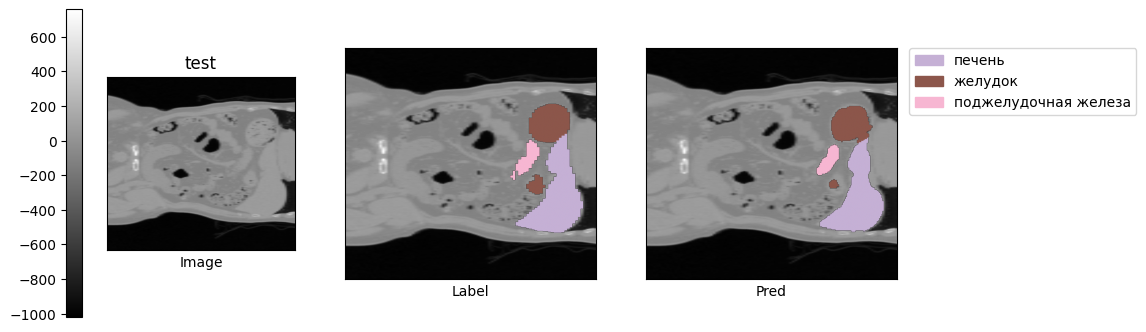

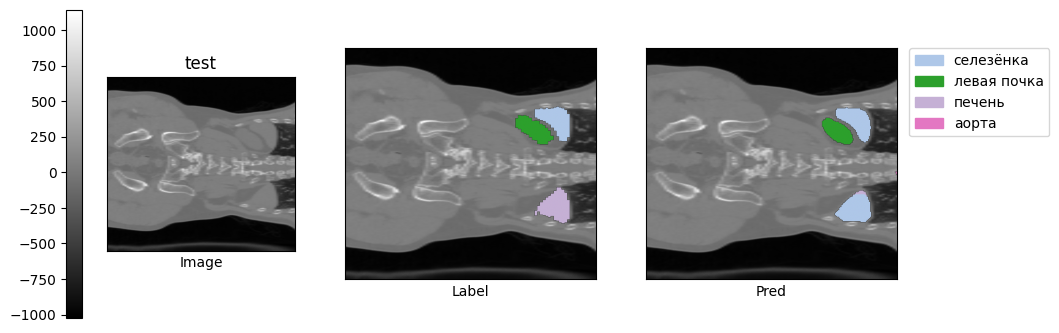

In [7]:
vis_predicts(model, 
             val_dataset, 
             10, 
             val_dataset.class_mapping, 
             val_dataset.reverse_class_mapping,
             overlay=True)

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    USED_CLASSES = [0, 1, 2, 3, 6, 7, 8, 9]

    IMAGE_SIZE: int = 224 # W, H
    BACKGROUND_CLS_ID: int = 0
    DATASET_PATH: str = 'data/default_dataset'
    AUGS = [A.HorizontalFlip(p=0.5), 
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.12, rotate_limit=0.15, shift_limit=0.12, p=0.5),
            ]


In [4]:
def create_class_mapping(used_classes):
    class_mapping = np.zeros(len(labels_dict), dtype=int)
    for new_class, original_class in enumerate(used_classes):
        class_mapping[original_class] = new_class
    return class_mapping

In [5]:
class_mapping = create_class_mapping(DatasetConfig.USED_CLASSES)

In [7]:
class OrgansDataset(Dataset):
    def __init__(self,
                dataset_path: str, 
                img_size: int,
                augs: List | None = None,
                cache: bool = False,
                clip_min: int | None = None,
                clip_max: int | None = None,
                ):
        super().__init__()
        self.use_cache = cache
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.clip_min = clip_min
        self.clip_max = clip_max

        for img_path in glob.glob(dataset_path + '/**/*img.npy', recursive=True):
            lbl_path = img2label(img_path)
            self.images.append(load_npy(img_path) if self.use_cache else img_path)
            self.labels.append(load_npy(img_path) if self.use_cache else lbl_path)

        transforms = []
        if augs is not None:
            transforms.extend(augs)
        transforms.extend([
                        A.Resize(self.img_size, self.img_size, always_apply=True),
                        ToTensorV2(always_apply=True)
                    ])
        self.transforms = A.Compose(transforms)

        
        
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index: int):
        image = self.images[index]
        label = self.labels[index]

        if not self.use_cache:
            image = load_npy(image)
            label = load_npy(label)
        
        image = normalize(image, 
                          min_val=self.clip_min,
                          max_val=self.clip_max,
                          )
        image = np.expand_dims(image, 2)
        label = class_mapping[label.astype(int)]
        transformed = self.transforms(image=image, mask=label)
        image, label = transformed["image"], transformed["mask"].to(torch.long)
        return image, label

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.pooling = F.max_pool2d
        self.pool_params = {"kernel_size":2, "stride":2}
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3,
                      padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=3,
                      padding = 1)
        )

    def forward(self, x):
        # encoder                                                  (size, features)

        e0 = self.enc_conv0(x) #(256, 32)
        e1 = self.enc_conv1(self.pooling(e0, **self.pool_params)) #(128, 64)
        e2 = self.enc_conv2(self.pooling(e1, **self.pool_params)) #(64, 128)
        e3 = self.enc_conv3(self.pooling(e2, **self.pool_params)) #(32, 256)

        b = self.bottleneck_conv(self.pooling(e3, **self.pool_params)) #(16, 256)


        d0 = self.dec_conv0(torch.cat((self.upsample(b), e3), 1)) #(32, 128)
        d1 = self.dec_conv1(torch.cat((self.upsample(d0), e2), 1)) #(64, 64)
        d2 = self.dec_conv2(torch.cat((self.upsample(d1), e1), 1)) #(128, 32)
        d3 = self.dec_conv3(torch.cat((self.upsample(d2), e0), 1)) #(256, 1)

        return d3

In [10]:
def dice_coef_loss(predictions, ground_truths, num_classes=2, dims=(1, 2), smooth=1e-8):
    """Smooth Dice coefficient."""
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
    dice = (2.0 * intersection + smooth) / (summation + smooth)

    dice_mean = dice.mean()

    return 1.0 - dice_mean

In [14]:
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassF1Score

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer, metric):
    model.train()
    running_loss = 0.0
    running_metric = 0
    processed_data = 0

    count = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels, num_classes=len(DatasetConfig.USED_CLASSES))
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_metric += metric(preds, labels)
        processed_data += inputs.size(0)
        count += 1

    train_loss = running_loss / processed_data
    train_metric = running_metric.cpu().numpy() / count
    return train_loss, train_metric

In [18]:
@torch.no_grad()
def eval_epoch(model, val_loader, criterion, metric):
    model.eval()
    running_loss = 0.0
    running_metric = 0
    processed_size = 0

    count = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels, num_classes=len(DatasetConfig.USED_CLASSES))
        preds = F.softmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_metric += metric(preds, labels)
        processed_size += inputs.size(0)
        count += 1

    val_loss = running_loss / processed_size
    val_metric = running_metric.double() / count
    return val_loss, val_metric.cpu().numpy()

In [19]:
from tqdm import tqdm

In [20]:
def train(model, epochs, train_loader, val_loader, optim, criterion, metric, learning_rate=0.001):

    best_model_wts = model.state_dict()
    best_metric = 0.0
    best_epoch = 0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_metric {t_metric:0.4f} val_metric {v_metric:0.4f}"

    
    opt = optim(model.parameters(), lr = learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min',
    #                                                        patience = 3,
    #                                                        threshold=0.001,
    #                                                        verbose = True,
    #                                                        factor  = 0.5)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=4,
    #                                                      verbose=True)

    for epoch in tqdm(range(epochs)):
        train_loss, train_metric = fit_epoch(model, train_loader, criterion, opt, metric)


        val_loss, val_metric = eval_epoch(model, val_loader, criterion, metric)
        # scheduler.step(val_loss)
        history.append((train_loss, train_metric, val_loss, val_metric))



        if val_metric > best_metric:
            best_metric = val_metric
            best_model_wts = model.state_dict()
            best_epoch = epoch

        print(f"\nEpoch {epoch:03d} train_loss: {train_loss:0.4f} \
    val_loss {val_loss:0.4f} train_metric {train_metric:0.4f} val_metric {val_metric:0.4f}")



    return history, best_model_wts, best_epoch

In [21]:
model = UNet(1, len(DatasetConfig.USED_CLASSES)).to(device)
metric = MulticlassF1Score(num_classes=len(DatasetConfig.USED_CLASSES), average="macro").to(device)
optimiser = optim.Adam
criterion = dice_coef_loss

In [53]:
train_dataset = OrgansDataset('data/train', DatasetConfig.IMAGE_SIZE, augs = DatasetConfig.AUGS)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = OrgansDataset('data/val', DatasetConfig.IMAGE_SIZE)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [23]:
history, best_model_wts, best_epoch = train(model, 50, train_loader, val_loader, optimiser, criterion, metric)

  2%|▏         | 1/50 [00:10<08:46, 10.74s/it]


Epoch 000 train_loss: 0.8123     val_loss 0.8618 train_metric 0.1926 val_metric 0.1497


  4%|▍         | 2/50 [00:21<08:30, 10.64s/it]


Epoch 001 train_loss: 0.7254     val_loss 0.7531 train_metric 0.3221 val_metric 0.3267


  6%|▌         | 3/50 [00:31<08:18, 10.61s/it]


Epoch 002 train_loss: 0.6689     val_loss 0.7118 train_metric 0.4114 val_metric 0.3811


  8%|▊         | 4/50 [00:42<08:07, 10.59s/it]


Epoch 003 train_loss: 0.6392     val_loss 0.6677 train_metric 0.4640 val_metric 0.4502


 10%|█         | 5/50 [00:52<07:54, 10.55s/it]


Epoch 004 train_loss: 0.6132     val_loss 0.6146 train_metric 0.5063 val_metric 0.5176


 12%|█▏        | 6/50 [01:03<07:43, 10.54s/it]


Epoch 005 train_loss: 0.5944     val_loss 0.7173 train_metric 0.5387 val_metric 0.3934


 14%|█▍        | 7/50 [01:13<07:32, 10.52s/it]


Epoch 006 train_loss: 0.5795     val_loss 0.7987 train_metric 0.5719 val_metric 0.2617


 16%|█▌        | 8/50 [01:24<07:22, 10.53s/it]


Epoch 007 train_loss: 0.5683     val_loss 0.5780 train_metric 0.5896 val_metric 0.5936


 18%|█▊        | 9/50 [01:35<07:12, 10.54s/it]


Epoch 008 train_loss: 0.5600     val_loss 0.6464 train_metric 0.6030 val_metric 0.5284


 20%|██        | 10/50 [01:45<07:02, 10.56s/it]


Epoch 009 train_loss: 0.5485     val_loss 0.5797 train_metric 0.6219 val_metric 0.5874


 22%|██▏       | 11/50 [01:56<06:51, 10.56s/it]


Epoch 010 train_loss: 0.5408     val_loss 0.6160 train_metric 0.6359 val_metric 0.5414


 24%|██▍       | 12/50 [02:06<06:41, 10.57s/it]


Epoch 011 train_loss: 0.5335     val_loss 0.5706 train_metric 0.6491 val_metric 0.6103


 26%|██▌       | 13/50 [02:17<06:31, 10.58s/it]


Epoch 012 train_loss: 0.5272     val_loss 0.6003 train_metric 0.6592 val_metric 0.5658


 28%|██▊       | 14/50 [02:28<06:21, 10.60s/it]


Epoch 013 train_loss: 0.5202     val_loss 0.5963 train_metric 0.6712 val_metric 0.5706


 30%|███       | 15/50 [02:38<06:10, 10.60s/it]


Epoch 014 train_loss: 0.5169     val_loss 0.5642 train_metric 0.6752 val_metric 0.6274


 32%|███▏      | 16/50 [02:49<06:00, 10.60s/it]


Epoch 015 train_loss: 0.5129     val_loss 0.6048 train_metric 0.6827 val_metric 0.5556


 34%|███▍      | 17/50 [02:59<05:49, 10.60s/it]


Epoch 016 train_loss: 0.5130     val_loss 0.5261 train_metric 0.6814 val_metric 0.6926


 36%|███▌      | 18/50 [03:10<05:39, 10.60s/it]


Epoch 017 train_loss: 0.5068     val_loss 0.5244 train_metric 0.6998 val_metric 0.6863


 38%|███▊      | 19/50 [03:20<05:28, 10.58s/it]


Epoch 018 train_loss: 0.4984     val_loss 0.5265 train_metric 0.7113 val_metric 0.6834


 40%|████      | 20/50 [03:31<05:18, 10.60s/it]


Epoch 019 train_loss: 0.4998     val_loss 0.5221 train_metric 0.7074 val_metric 0.6917


 42%|████▏     | 21/50 [03:42<05:06, 10.59s/it]


Epoch 020 train_loss: 0.4951     val_loss 0.5345 train_metric 0.7150 val_metric 0.6782


 44%|████▍     | 22/50 [03:52<04:57, 10.61s/it]


Epoch 021 train_loss: 0.4893     val_loss 0.5075 train_metric 0.7304 val_metric 0.7203


 46%|████▌     | 23/50 [04:03<04:47, 10.63s/it]


Epoch 022 train_loss: 0.4869     val_loss 0.5209 train_metric 0.7312 val_metric 0.7001


 48%|████▊     | 24/50 [04:14<04:36, 10.62s/it]


Epoch 023 train_loss: 0.4882     val_loss 0.5318 train_metric 0.7277 val_metric 0.6718


 50%|█████     | 25/50 [04:24<04:25, 10.62s/it]


Epoch 024 train_loss: 0.4830     val_loss 0.5436 train_metric 0.7422 val_metric 0.6311


 52%|█████▏    | 26/50 [04:35<04:15, 10.65s/it]


Epoch 025 train_loss: 0.4836     val_loss 0.5915 train_metric 0.7342 val_metric 0.6025


 54%|█████▍    | 27/50 [04:46<04:05, 10.66s/it]


Epoch 026 train_loss: 0.4797     val_loss 0.5057 train_metric 0.7417 val_metric 0.7207


 56%|█████▌    | 28/50 [04:56<03:54, 10.67s/it]


Epoch 027 train_loss: 0.4754     val_loss 0.5091 train_metric 0.7489 val_metric 0.7214


 58%|█████▊    | 29/50 [05:07<03:45, 10.76s/it]


Epoch 028 train_loss: 0.4745     val_loss 0.4902 train_metric 0.7541 val_metric 0.7408


 60%|██████    | 30/50 [05:18<03:34, 10.73s/it]


Epoch 029 train_loss: 0.4738     val_loss 0.4966 train_metric 0.7502 val_metric 0.7226


 62%|██████▏   | 31/50 [05:29<03:23, 10.73s/it]


Epoch 030 train_loss: 0.4733     val_loss 0.5989 train_metric 0.7506 val_metric 0.5861


 64%|██████▍   | 32/50 [05:39<03:12, 10.71s/it]


Epoch 031 train_loss: 0.4703     val_loss 0.5383 train_metric 0.7590 val_metric 0.6589


 66%|██████▌   | 33/50 [05:50<03:01, 10.68s/it]


Epoch 032 train_loss: 0.4677     val_loss 0.5189 train_metric 0.7660 val_metric 0.7099


 68%|██████▊   | 34/50 [06:01<02:50, 10.64s/it]


Epoch 033 train_loss: 0.4665     val_loss 0.4803 train_metric 0.7684 val_metric 0.7749


 70%|███████   | 35/50 [06:11<02:39, 10.64s/it]


Epoch 034 train_loss: 0.4683     val_loss 0.4971 train_metric 0.7660 val_metric 0.7275


 72%|███████▏  | 36/50 [06:22<02:29, 10.65s/it]


Epoch 035 train_loss: 0.4642     val_loss 0.5223 train_metric 0.7709 val_metric 0.7051


 74%|███████▍  | 37/50 [06:32<02:18, 10.65s/it]


Epoch 036 train_loss: 0.4644     val_loss 0.4947 train_metric 0.7750 val_metric 0.7467


 76%|███████▌  | 38/50 [06:43<02:07, 10.65s/it]


Epoch 037 train_loss: 0.4604     val_loss 0.4971 train_metric 0.7803 val_metric 0.7491


 78%|███████▊  | 39/50 [06:54<01:57, 10.65s/it]


Epoch 038 train_loss: 0.4587     val_loss 0.5039 train_metric 0.7812 val_metric 0.7230


 80%|████████  | 40/50 [07:05<01:46, 10.67s/it]


Epoch 039 train_loss: 0.4575     val_loss 0.4972 train_metric 0.7858 val_metric 0.7522


 82%|████████▏ | 41/50 [07:15<01:36, 10.67s/it]


Epoch 040 train_loss: 0.4583     val_loss 0.4969 train_metric 0.7836 val_metric 0.7380


 84%|████████▍ | 42/50 [07:26<01:25, 10.65s/it]


Epoch 041 train_loss: 0.4708     val_loss 0.4636 train_metric 0.5210 val_metric 0.1873


 86%|████████▌ | 43/50 [07:36<01:14, 10.65s/it]


Epoch 042 train_loss: 0.4517     val_loss 0.4345 train_metric 0.2137 val_metric 0.2165


 88%|████████▊ | 44/50 [07:47<01:03, 10.65s/it]


Epoch 043 train_loss: 0.4426     val_loss 0.4375 train_metric 0.2222 val_metric 0.2128


 90%|█████████ | 45/50 [07:58<00:53, 10.63s/it]


Epoch 044 train_loss: 0.4378     val_loss 0.4243 train_metric 0.2273 val_metric 0.2268


 92%|█████████▏| 46/50 [08:08<00:42, 10.62s/it]


Epoch 045 train_loss: 0.4388     val_loss 0.4264 train_metric 0.2250 val_metric 0.2261


 94%|█████████▍| 47/50 [08:19<00:31, 10.63s/it]


Epoch 046 train_loss: 0.4337     val_loss 0.4454 train_metric 0.2307 val_metric 0.2046


 96%|█████████▌| 48/50 [08:30<00:21, 10.63s/it]


Epoch 047 train_loss: 0.4338     val_loss 0.4158 train_metric 0.2308 val_metric 0.2327


 98%|█████████▊| 49/50 [08:40<00:10, 10.62s/it]


Epoch 048 train_loss: 0.4312     val_loss 0.4233 train_metric 0.2329 val_metric 0.2286


100%|██████████| 50/50 [08:51<00:00, 10.63s/it]


Epoch 049 train_loss: 0.4307     val_loss 0.4166 train_metric 0.2338 val_metric 0.2316


In [24]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [55]:
indices = range(len(val_dataset))
indices = random.sample(indices, 10)

In [57]:
reverse_class_mapping = np.array(DatasetConfig.USED_CLASSES)

In [72]:
import cv2

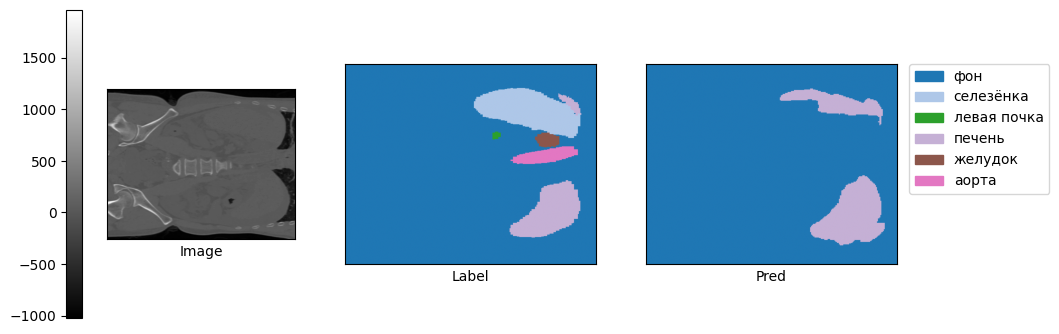

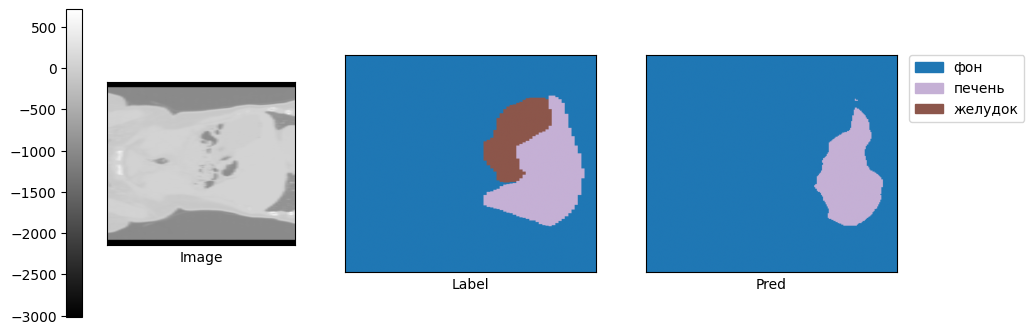

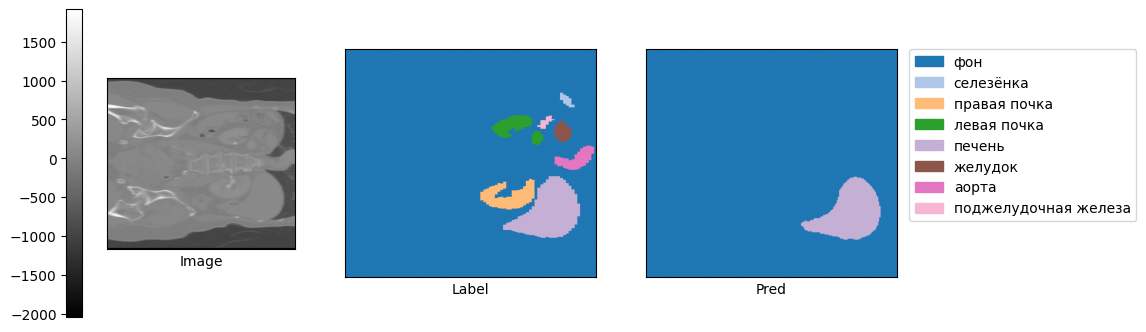

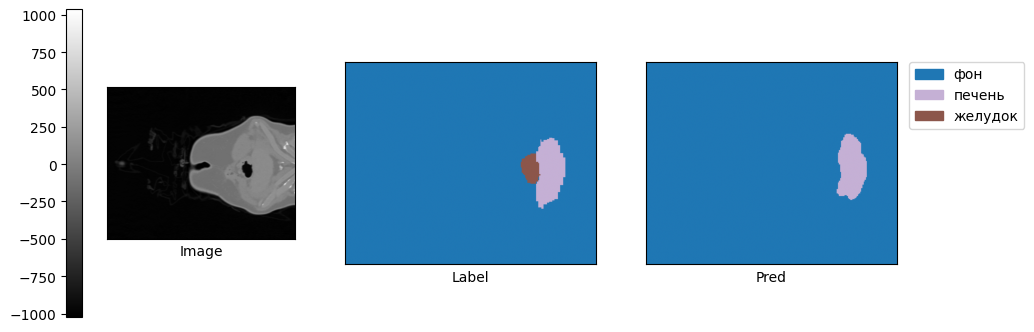

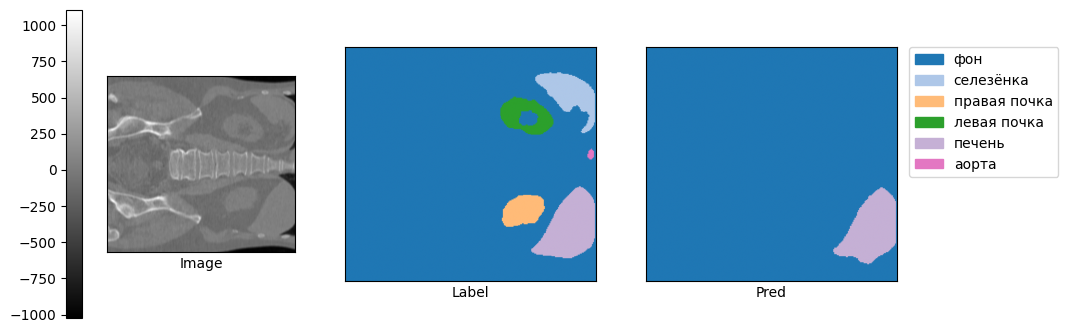

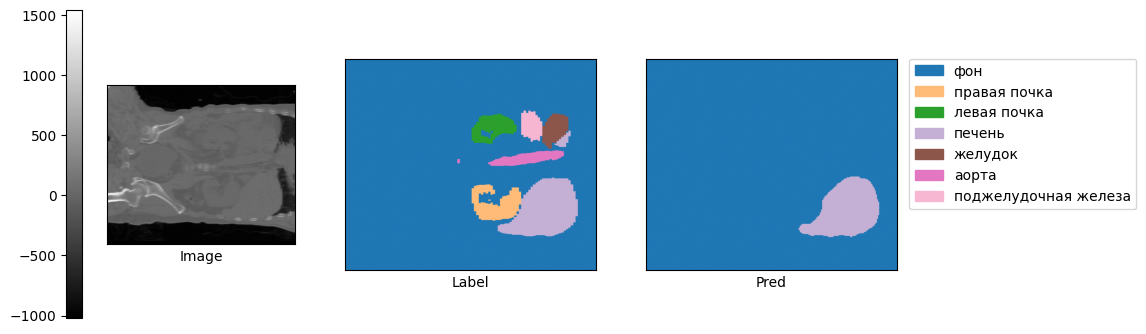

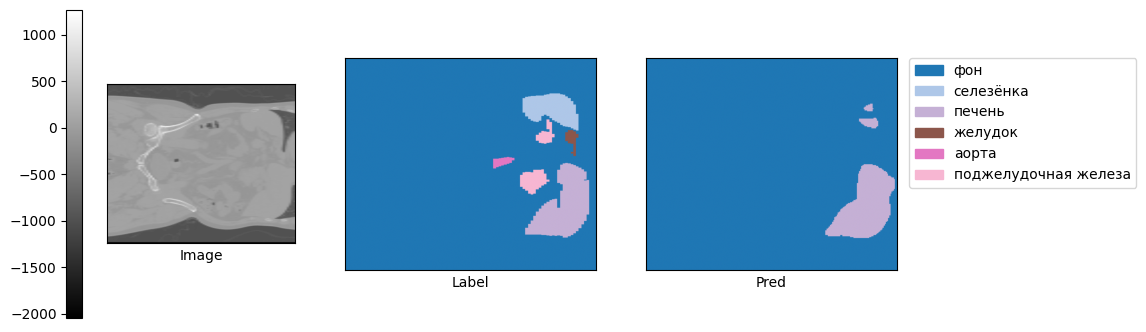

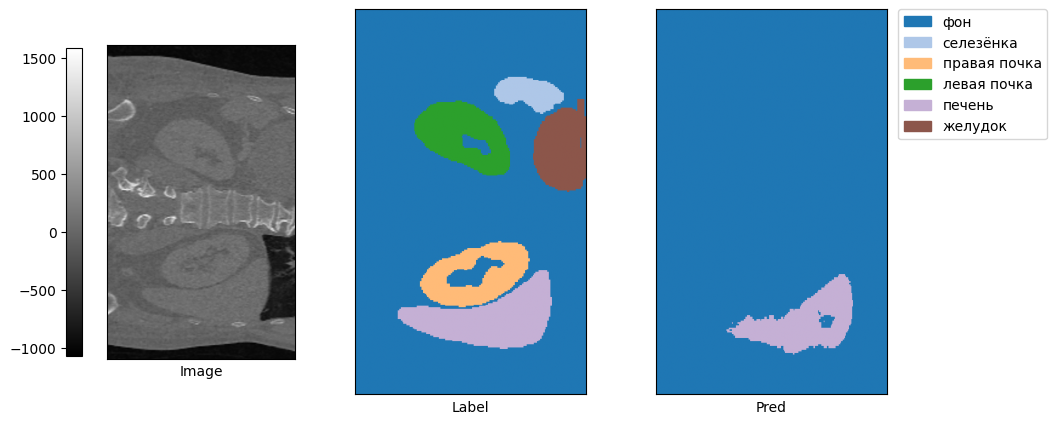

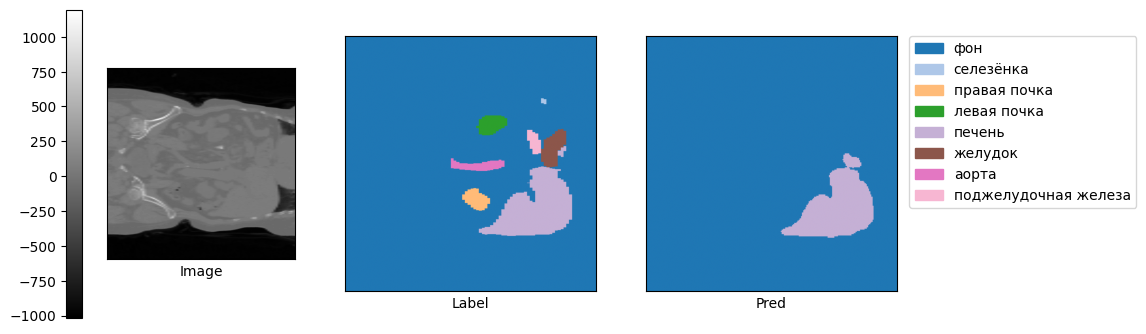

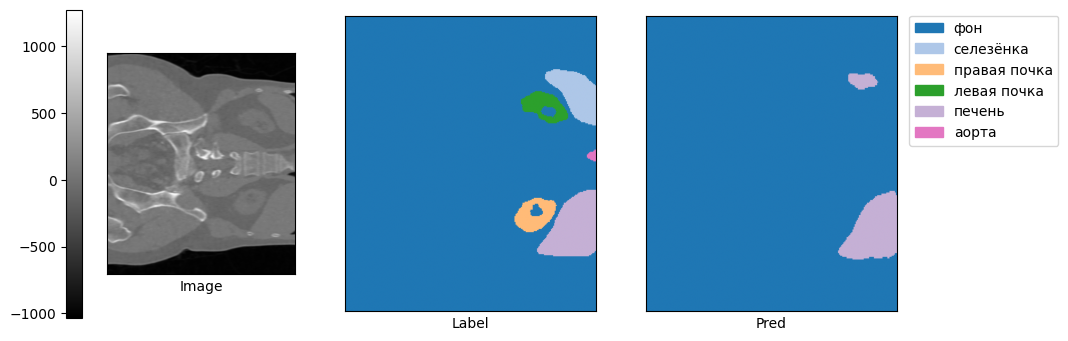

In [73]:
def vis_val_predicts(model, val_dataset, n_samples):

    indices = range(len(val_dataset))
    indices = random.sample(indices, n_samples)
    with torch.no_grad():
        model.eval()
        for i in indices:
            image_path = val_dataset.images[i]
            image = load_npy(image_path)
            label = load_npy(img2label(image_path))
            label = class_mapping[label.astype(int)]
            label = reverse_class_mapping[label.astype(int)]
        
            image_tensor, _ = val_dataset[i]
            image_tensor = image_tensor.to(device)
            outputs = model(image_tensor.unsqueeze(0))
            outputs = F.softmax(outputs, dim=1)
            outputs = torch.argmax(outputs, dim=1).permute(0, 1, 2).squeeze(0)
            outputs = outputs.cpu().detach().numpy()
            outputs = reverse_class_mapping[outputs]
            outputs = cv2.resize(outputs, (label.shape[1], label.shape[0]), interpolation=cv2.INTER_NEAREST)
            vis_one(image, label, 'test', pred=outputs)


In [47]:
image_path = val_dataset.images[200]

In [48]:
image = load_npy(image_path)
label = load_npy(img2label(image_path))

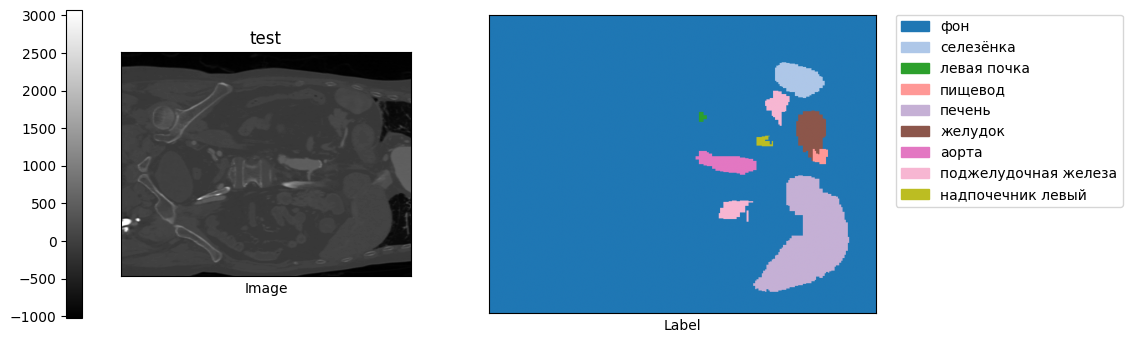

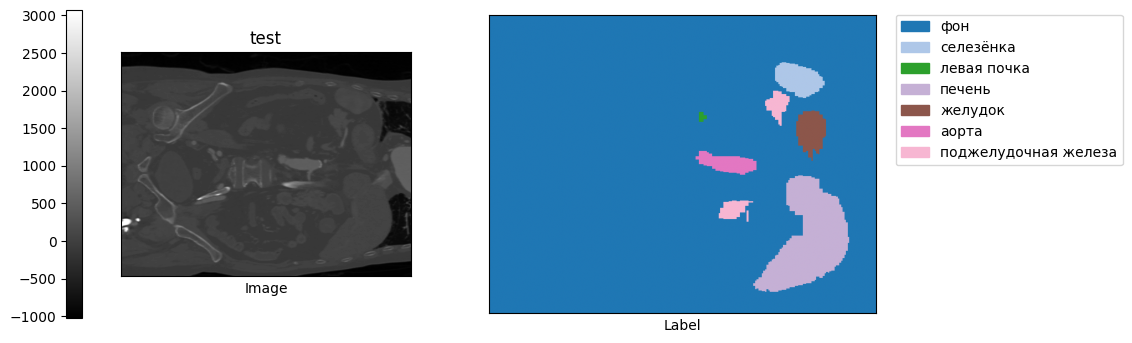

In [49]:
vis_one(image, label, 'test')
label = class_mapping[label.astype(int)]
label = np.array(DatasetConfig.USED_CLASSES)[label.astype(int)]
vis_one(image, label, 'test')
